# Depth scale experiments on MNIST and CIFAR-10
In this notebook, we provide code to reproduce Figure 6 in the paper. 

In [95]:
# required imports
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patheffects as PathEffects
import seaborn as sns
from matplotlib.collections import LineCollection

# custom imports
from src.theory import fixed_point
from src.theory import c_map
from src.theory import c_map_slope
from src.theory import depth
from src.theory import critical_point
from src.theory import depth_scale

# plot settings
matplotlib.rcParams['font.size'] = 100
sns.set_context("paper", font_scale=2)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

### --- Variance dynamics and depth scales for noisy ReLU networks on MNIST and CIFAR-10 ---

/Users/elanvanbiljon/git_repos/noisy_signal_prop/src/theory.py:206: RuntimeWarning: divide by zero encountered in log10
  ret_val[shrinking_ps] = (np.log10(shrink_value) - np.log10(q_0))/np.log10(growth_rate[shrinking_ps])
/Users/elanvanbiljon/git_repos/noisy_signal_prop/src/theory.py:249: RuntimeWarning: divide by zero encountered in true_divide
  return -1/(np.log(xi))


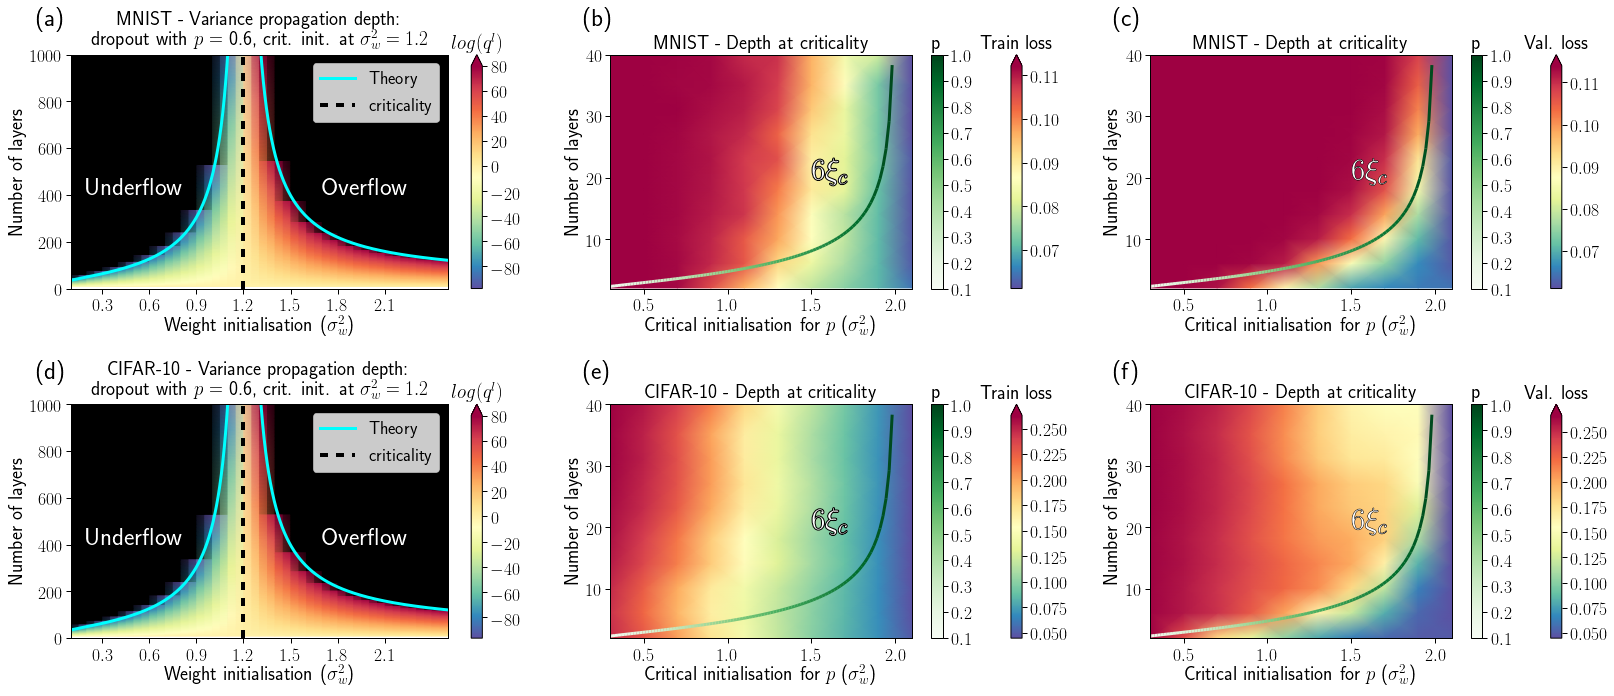

In [100]:
shading = "gouraud"

rates = np.linspace(0.1, 1, 100)
mu2s = 1/rates
fps = []
fp_slopes = []
for p in rates:
    mu2 = 1/p
    fpoint = fixed_point(c_map, p, p*2, mu2)
    fps.append(fpoint)

    slope = c_map_slope(fpoint, p*2)
    fp_slopes.append(slope)

fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, figsize=(23, 10))

for dataset, [ax1, ax2, ax3] in zip(["mnist", "cifar-10"], [[ax1, ax2, ax3], [ax4, ax5, ax6]]):
    
    ###############################
    # Variance propagation dynamics
    ###############################
    example_dict = np.load("src/results/variance_depth/{}/variance_depth.npy".format(dataset.replace("-", "")))
    inits = np.load("src/results/variance_depth/{}/variance_depth_sigma.npy".format(dataset.replace("-", "")))
    p = 0.6
    num_layers = 1000
    nets = np.linspace(10, num_layers, 1000, dtype=int)
    xv, yv = np.meshgrid(nets, inits, sparse=False, indexing='ij')

    Z1 = np.log(np.array(example_dict))

    bad_indices = np.isnan(Z1) + np.isinf(Z1)
    Z1 = np.ma.array(Z1, mask=bad_indices)
    cmap = matplotlib.cm.get_cmap(name="Spectral_r")
    cmap.set_bad('black')

    pcm = ax1.pcolormesh(yv, xv, Z1.T, cmap=cmap, shading=shading, linewidth=0)
    cbar = fig.colorbar(pcm, ax=ax1, extend='max')
    cbar.ax.set_title('$log(q^l)$')

    ax1.set_xlabel('Weight initialisation ($\sigma^2_w$)')
    ax1.set_ylabel("Number of layers")
    ax1.set_title("{} - Variance propagation depth:\ndropout with $p$ = 0.6, crit. init. at $\sigma^2_w = 1.2$".format(dataset.upper()))

    max_depth = 0
    init_theory = np.linspace(0, 2.5, 1000)
    depth_per_p_theory = depth("Dropout", init_theory, p)
    max_depth = np.max([max_depth, np.max(depth_per_p_theory)])
    ax1.plot(init_theory, depth_per_p_theory, label="Theory", c='cyan', linewidth=3)

    crit_point = critical_point("Dropout", p)
    ax1.plot([crit_point,]*2, [0, num_layers], color="black", linestyle="--", label="criticality", linewidth=4, dashes=(2, 2))

    ax1.set_ylim(0, 1000)
    ax1.set_xlim(0.1, 2.5)
    ax1.legend()
    ax1.set_xticks(inits[2:-2:3])
    ax1.text(0.2, 400, 'Underflow', fontsize=25, color="white")
    ax1.text(1.7, 400, 'Overflow', fontsize=25, color="white")
    
    rates = np.linspace(0.1, 1, 100)
    
    
    if dataset == "cifar-10":
        example_dict = np.load("src/results/trainable_depth/{}/trainable_depth.npy".format(dataset.replace("-", "")))
        example_dict = example_dict[:, :, -1, 0].T
    elif dataset == "mnist":
        pickle_in = open("src/results/val_loss_per_depth.pk","rb")
        example_dict = np.array(pickle.load(pickle_in))[:, 0]
    else:
        raise ValueError("dataset not supported")

    nets = np.linspace(2, 40, 10, dtype=int)
    d_rates = 2*np.linspace(0.1, 1, 10)
    xv, yv = np.meshgrid(nets, d_rates, sparse=False, indexing='ij')

    Z1 = np.array(example_dict)
    pcm = ax2.pcolormesh(yv+0.1, xv+0.1, Z1.reshape(10,10), cmap='Spectral_r', shading=shading, linewidth=0)
    cbar1 = fig.colorbar(pcm, ax=ax2, extend='max')
    cbar1.ax.set_title('Train loss')
    
    ################################
    # Training loss and depth scales
    ################################
    t = rates 
    x = 2*rates
    y = 6*depth_scale(fp_slopes)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('Greens'))
    lc.set_array(t)
    lc.set_linewidth(3)
    cbar2 = fig.colorbar(lc, ax=ax2)
    cbar2.ax.set_title('p')

    ax2.add_collection(lc)
    ax2.set_xlabel("Critical initialisation for $p$ ($\sigma^2_w$)")
    ax2.set_ylabel("Number of layers")
    txt = ax2.text(1.5, 19, r'$6\xi_c$', fontsize=30, color="white")
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='black')])
    ax2.set_title("{} - Depth at criticality".format(dataset.upper()))
    ax2.set_xlim(0.3, 2.1)
    ax2.set_ylim(2, 40)
    
    if dataset == "cifar-10":
        example_dict = np.load("src/results/trainable_depth/{}/trainable_depth.npy".format(dataset.replace("-", "")))
        example_dict = example_dict[:, :, -1, 1].T
    elif dataset == "mnist":
        pickle_in = open("src/results/val_loss_per_depth.pk","rb")
        example_dict = np.array(pickle.load(pickle_in))[:,1]
    else:
        raise ValueError("dataset not supported")

    nets = np.linspace(2, 40, 10, dtype=int)
    d_rates = 2*np.linspace(0.1, 1, 10)
    xv, yv = np.meshgrid(nets, d_rates, sparse=False, indexing='ij')

    Z1 = np.array(example_dict)
    pcm = ax3.pcolormesh(yv+0.1, xv+0.1, Z1.reshape(10,10), cmap='Spectral_r', shading=shading, linewidth=0)
    cbar1 = fig.colorbar(pcm, ax=ax3, extend='max')
    cbar1.ax.set_title('Val. loss')

    ##################################
    # Validation loss and depth scales
    ##################################
    t = rates 
    x = 2*rates
    y = 6*depth_scale(fp_slopes)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments, cmap=plt.get_cmap('Greens'))
    lc.set_array(t)
    lc.set_linewidth(3)
    cbar2 = fig.colorbar(lc, ax=ax3)
    cbar2.ax.set_title('p')

    ax3.add_collection(lc)
    ax3.set_xlabel("Critical initialisation for $p$ ($\sigma^2_w$)")
    ax3.set_ylabel("Number of layers")
    txt = ax3.text(1.5, 19, r'$6\xi_c$', fontsize=30, color="white")
    txt.set_path_effects([PathEffects.withStroke(linewidth=1, foreground='black')])
    ax3.set_title("{} - Depth at criticality".format(dataset.upper()))
    ax3.set_xlim(0.3, 2.1)
    ax3.set_ylim(2, 40)

##############
# add labels #
##############
fig.text(0.03, 0.95, "(a)", fontsize=25)
fig.text(0.36, 0.95, "(b)", fontsize=25)
fig.text(0.68, 0.95, "(c)", fontsize=25)
fig.text(0.03, 0.46, "(d)", fontsize=25)
fig.text(0.36, 0.46, "(e)", fontsize=25)
fig.text(0.68, 0.46, "(f)", fontsize=25)

plt.gcf().tight_layout()
plt.show()
# plt.savefig("depth_scales.pdf", dpi=200)

$\textit{Depth scale experiments on MNIST and CIFAR-10.}$ $\textbf{(a)}$: Variance propagation dynamics for MNIST on and off the critical point initialisation (dashed black line) with dropout ($p = 0.6$). The cyan curve represents the theoretical boundary at which numerical instability issues are predicted to occur and is computed as $L^* = \text{ln}(K)/\text{ln}(\frac{\sigma^2_w}{2}\mu_2)$, where $K$ is the largest (or smallest) positive number representable by the computer. Specifically, we use $32$-bit floating point numbers and set $K = 3.4028235\times 10^{38}$, if $\sigma^2_w > \frac{2}{\mu_2}$ and $K = 1.1754944\times 10^{-38}$, if $\sigma^2_w < \frac{2}{\mu_2}$. $\textbf{(b)}$: Depth scales fit to the training loss on MNIST for networks initialised at criticality for dropout rates $p=0.1$ (severe dropout) to $p=1$ (no dropout). $\textbf{(c)}$: Depth scales fit to the validation loss on MNIST. $\textbf{(d) - (f)}$: Similar to (a) - (c), but for CIFAR-10.